<a href="https://colab.research.google.com/github/pauljhp/Auto_Stockselection/blob/main/NADAQ_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales, margin forecast & stock classification for NASDAQ companies

In [ ]:
!pip install secedgar

In [ ]:
import secedgar
from secedgar.cik_lookup import CIKLookup
from google.colab import drive
import pandas as pd
import numpy as np
from collections import deque, Counter
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l /content/drive/MyDrive/stockClassification

total 608897
-rw------- 1 root root    794909 Oct 20 12:39 '2021-10-19 recommendations.csv'
-rw------- 1 root root       151 Oct 20 09:48 '2021-10-19 recommendations.gsheet'
-rw------- 1 root root      8135 Oct 20 09:26  2_2recommendation.csv
-rw------- 1 root root  21194535 Dec 13 09:41  businessdescription_nasdaq.csv
-rw------- 1 root root     50426 Dec 12 16:10  ciks.txt
-rw------- 1 root root  19471313 Dec 13 08:43  data1_nasdaq.csv
-rw------- 1 root root  76375103 Dec 13 08:43  data2_nasdaq.csv
-rw------- 1 root root   1195930 Dec 13 10:51  kmeans_busdesc.csv
-rw------- 1 root root    432212 Oct 18 14:47  msci_china_classification_test.csv
-rw------- 1 root root   6404769 Oct 19 14:14  MXCN.csv
-rw------- 1 root root    821118 Oct 20 07:16  mxcn_inf2021-10-19.csv
-rw------- 1 root root    129049 Dec 13 14:43 'NADAQ Classification.ipynb'
-rw------- 1 root root 364693602 Dec 12 02:43  nasdaq_financial_ratios.csv
-rw------- 1 root root  71709493 Dec 12 16:53  nasdaq_financials.csv
-r

## **0. Get CIK lookup table**

In [ ]:
# Get CIKs
df = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_screener_1639275261400.csv", header=0, index_col=0)
for i, d in enumerate(df.index):
    if i % 100 == 0:
        print(f"{i/len(df)*100:.2f}% done")
    cl = CIKLookup(str(d))
    try:
        cikobj = cl.get_ciks()
        cik = cikobj[str(d)]
        df.loc[d, 'cik'] = cik
    except AttributeError as e:
        print(e, "skipped")
    except Exception as e:
        print(e, "skipped")
# df.to_csv("/content/drive/MyDrive/stockClassification/nasdaq_screener_withcik.csv")
# ciks = "\n".join(df.cik.astype(str).unique())
# with open("/content/drive/MyDrive/stockClassification/ciks.txt", "w") as f:
#     f.write(ciks)

0.00% done
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
1.21% done
 skipped
 skipped
 skipped
 skipped
 skipped
2.43% done
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
3.64% done
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
4.85% done
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
6.06% done
 skipped
 skipped
 skipped
 skipped
 skipped
7.28% done
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
8.49% done
 skipped
9.70% done
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
10.91% done
 skipped
 skipped
 skipped
 skipped
 skipped
 skipped
12.13% done
 skipped
 skipped
 skipped
 skipped
 skipped
13.34% done
 skipped
 skipped
 skipped
 skipped
 

In [ ]:
# lookup table for ciks
cik_lookup = df.groupby(["cik", "Symbol"]).size().to_frame()
cik_lookup.reset_index(["cik", "Symbol"], inplace=True)
cik_lookup.drop(0, axis="columns", inplace=True)
cik_lookup.set_index('cik', inplace=True)
cik_lookup = Counter({int(cik): row.values[0] for cik, row in cik_lookup.iterrows()})

## **1. Preprocessing datasets**

In [ ]:
data1 = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_financials.csv", header=0, index_col=0)
data2 = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_financial_ratios.csv", header=0, index_col=0)

### 1.1 Formatting data

In [ ]:
# process data2
data2 = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_financial_ratios.csv", header=0, index_col=0)
data2.qdate = data2.qdate.apply(lambda d: datetime.strptime(str(d), "%Y/%m/%d") if type(d) is str else np.nan)
data2.public_date = data2.public_date.apply(lambda d: datetime.strptime(str(d), "%Y/%m/%d") if type(d) is str else np.nan)
data2['year'] = data2.qdate.apply(lambda d: int(d.year) if type(d) is pd.Timestamp else np.nan)
data2.divyield = data2.divyield.str.replace("%", "").astype(float).apply(lambda d: d/100)

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835923 entries, 10009 to 93436
Data columns (total 74 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   adate            829240 non-null  object        
 1   qdate            835821 non-null  datetime64[ns]
 2   public_date      835923 non-null  datetime64[ns]
 3   CAPEI            788477 non-null  float64       
 4   bm               804967 non-null  float64       
 5   evm              823540 non-null  float64       
 6   pe_op_basic      801109 non-null  float64       
 7   pe_op_dil        617939 non-null  float64       
 8   pe_exi           810538 non-null  float64       
 9   pe_inc           811524 non-null  float64       
 10  ps               812893 non-null  float64       
 11  pcf              824337 non-null  float64       
 12  dpr              619501 non-null  float64       
 13  npm              812871 non-null  float64       
 14  opmbd            

In [ ]:
# group by ticker by year
newdata = data2.groupby(["TICKER", "year"]).mean().unstack("year")

In [ ]:
newdata.to_csv("/content/drive/MyDrive/stockClassification/data2_nasdaq.csv")

In [ ]:
def slice_data(data, filtername, filtercriteria):
    return data.iloc[:, data.columns.get_level_values(filtername) < filtercriteria]

slice_data(newdata, 'year', 2000)

CAPEI                        ...  divyield                    
year      1989.0    1990.0      1991.0  ...    1997.0    1998.0    1999.0
TICKER                                  ...                              
A       -2.20950  -1.49950         NaN  ...       NaN       NaN       NaN
AA      12.84875  11.34075   11.164833  ...  0.013292  0.014667  0.012967
AABC         NaN       NaN         NaN  ...       NaN  0.006944  0.006329
AAC     14.86425   7.99975    9.915750  ...       NaN       NaN       NaN
AACI         NaN       NaN -150.853667  ...       NaN       NaN       NaN
...          ...       ...         ...  ...       ...       ...       ...
ZUMZ         NaN       NaN         NaN  ...       NaN       NaN       NaN
ZUO          NaN       NaN         NaN  ...       NaN       NaN       NaN
ZVO          NaN       NaN         NaN  ...       NaN       NaN       NaN
ZYNE         NaN       NaN         NaN  ...       NaN       NaN       NaN
ZYXI         NaN       NaN         NaN  ...       NaN       NaN       NaN

[5967 rows x 759 columns]

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106927 entries, 1004 to 347085
Data columns (total 88 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datadate  106927 non-null  int64         
 1   fyear     106843 non-null  float64       
 2   indfmt    106927 non-null  object        
 3   consol    106927 non-null  object        
 4   popsrc    106927 non-null  object        
 5   datafmt   106927 non-null  object        
 6   tic       106927 non-null  object        
 7   cusip     106927 non-null  object        
 8   conm      106927 non-null  object        
 9   curcd     106843 non-null  object        
 10  fyr       106843 non-null  float64       
 11  acqgdwl   8057 non-null    float64       
 12  acqintan  7950 non-null    float64       
 13  act       66163 non-null   float64       
 14  am        65481 non-null   float64       
 15  ao        97102 non-null   float64       
 16  ap        88568 non-null   float64 

In [ ]:
# process data1
# load in data
data1 = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_financials.csv", header=0, index_col=0)

# Add Tickers according to CIK
# data1['TICKER'] = data1.cik.apply(lambda cik: cik_lookup.get(cik))
data1.ipodate = data1.ipodate.astype(str).apply(lambda d: datetime.strptime(str(d), "%Y-%m-%d") if not d=='nan' else np.nan) # type float64
data1['ipoyear'] = data1.ipodate.apply(lambda d: int(d.year) if type(d) is pd.Timestamp else np.nan)
# data1.to_csv("/content/drive/MyDrive/stockClassification/nasdaq_financials.csv")

In [ ]:
newdata1 = data1.loc[:, ['fyear', 'act', 'am',
       'ao', 'ap', 'aqc', 'arc', 'artfs', 'at', 'bast', 'capx', 'capxv',
       'cdvc', 'dltis', 'dltr', 'dltt', 'drc', 'drlt', 'dvt', 'ebit', 'ebitda',
       'emp', 'fincf', 'fopo', 'fopt', 'ivncf', 'ni', 'oancf', 'pi', 'sale',
       'seq', 'spid', 'tie', 'tii', 'udpfa', 'unwcc', 'wcap', 'xdp', 'xrd',
       'xsga', 'xstf', 'xstfo', 'TICKER',]].groupby(["TICKER", "fyear"]).mean().unstack("fyear")

In [ ]:
# grouping and slicing data1
newdata1 = data1.groupby(["TICKER", "fyear"]).mean().unstack("fyear")
slice_data(newdata1, 'fyear', 2000)

datadate                          ... ipoyear                
fyear    1989.0      1990.0      1991.0  ...  1997.0  1998.0  1999.0
TICKER                                   ...                        
A           NaN         NaN         NaN  ...     NaN  1999.0  1999.0
AA          NaN         NaN         NaN  ...     NaN     NaN     NaN
AAC         NaN         NaN         NaN  ...     NaN     NaN     NaN
AACG        NaN         NaN         NaN  ...     NaN     NaN     NaN
AAL         NaN  19901231.0  19911231.0  ...     NaN     NaN     NaN
...         ...         ...         ...  ...     ...     ...     ...
ZWS         NaN         NaN         NaN  ...     NaN     NaN     NaN
ZY          NaN         NaN         NaN  ...     NaN     NaN     NaN
ZYME        NaN         NaN         NaN  ...     NaN     NaN     NaN
ZYNE        NaN         NaN         NaN  ...     NaN     NaN     NaN
ZYXI        NaN         NaN         NaN  ...     NaN     NaN     NaN

[5426 rows x 781 columns]

In [ ]:
newdata1.isna().sum(axis='index')

          fyear 
datadate  1989.0    5260
          1990.0    4256
          1991.0    4182
          1992.0    4047
          1993.0    3935
                    ... 
ipoyear   2017.0    2663
          2018.0    2403
          2019.0    2233
          2020.0    2190
          2021.0    5148
Length: 2343, dtype: int64

In [ ]:
newdata = pd.read_csv("/content/drive/MyDrive/stockClassification/data2_nasdaq.csv", header=0, index_col=0)
newdata1 = pd.read_csv("/content/drive/MyDrive/stockClassification/data1_nasdaq.csv", header=0, index_col=0)

### **1.2 Clusting with business description text** - for adding features

In [ ]:

# left = slice_data(newdata1, 'fyear', 2000)
# merged = left.merge(desc, how='outer', left_on='TICKER', right_on='TICKER')
# merged = merged.merge(slice_data(newdata, 'year', 2000), how='outer', left_on='TICKER', right_on='TICKER')
# merged

In [ ]:
# tokenize business desc for clustering
import nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from itertools import chain
from collections import Counter
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stopwords_set = set(stopwords.words('english'))
custom_stopwords = ['group', 'inc', 'inc.', 'ltd', 'company', 'co', 'co.', 'operates',
        'united', 'state', 'service', 'provides', 'product', 'holding', 'segment',
        'subsidiary', 'market', ',', "'", ")", "(", ":", "&", "'s", ".", 'corp', 
]

for stopword in custom_stopwords:
    stopwords_set.add(stopword)

# desc.busdesc
# tokenize sentences
desc = data1.query("fyear==2020").loc[:, ['TICKER', 'busdesc', 'ggroup', 'gind',	
                                          'gsector', 'gsubind', 'priusa', 'sic', 
                                          'spcindcd', 'spcseccd', 'spcsrc']]
desc['tokens'] = desc.busdesc.astype(str).apply(lambda t: word_tokenize(t.lower()))
lmtz = WordNetLemmatizer()
desc['tokens'] = desc.tokens.apply(lambda l: [lmtz.lemmatize(t) for t in l])

all_words_sample = np.array(list(chain.from_iterable(desc.sample(n=2000).tokens)))
all_words = Counter(all_words_sample)
most_common_words = [k for k, _ in all_words.most_common(2000) if k not in stopwords_set] # most common 2000 tokens

# add words that appeared in >10% of tickers to the custome stopwords set
length = len(desc)
meaningless_words = {tok: desc.tokens.apply(lambda ts: tok in ts).sum() / length 
                    for tok in most_common_words
                    if desc.tokens.apply(lambda ts: tok in ts).sum() / length > 0.1}
custom_stopwords += list(meaningless_words.keys())

def get_token_freq(list_of_tokens, keyword_map):
    return [np.count_nonzero(np.array(list_of_tokens) == w) / len(list_of_tokens) 
            for w in keyword_map]

desc['token_freq'] = desc.tokens.apply(lambda ls: get_token_freq(ls, most_common_words))

def unseenTokens(list_of_tokens, keyword_map):
    return sum([((w not in keyword_map) and (w not in stopwords_set)) for w in list_of_tokens])/len(list_of_tokens)

desc['unseen_tokens'] = desc.tokens.apply(lambda ls: unseenTokens(ls, most_common_words))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# transform desc dataframe
desc = desc.loc[:, ['TICKER', 'ggroup', 'gind', 'gsector', 'gsubind', 'token_freq', 'unseen_tokens']]
busdesc = pd.DataFrame(dtype=int, columns=most_common_words + ['unseen_tokens'], index=desc.TICKER.unique())
for ticker, _ in busdesc.iterrows():
    busdesc.loc[ticker, :] = desc.query(f"TICKER=='{ticker}'").token_freq.iloc[0] + [desc.query(f"TICKER=='{ticker}'").unseen_tokens.iloc[0]]

In [ ]:
busdesc.iloc[1, -1]

0.0

In [ ]:
busdesc.to_csv("/content/drive/MyDrive/stockClassification/businessdescription_nasdaq.csv")

In [ ]:
# PCA
busdesc = pd.read_csv("/content/drive/MyDrive/stockClassification/businessdescription_nasdaq.csv", index_col=0, header=0)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

n_pcs = 50
pca = PCA(n_components=n_pcs)
pca.fit(busdesc)
busdesc_pca_ = pd.DataFrame(pca.transform(busdesc), 
                            columns=["pc" + str(i) for i in range(1, n_pcs+1)], 
                            index=busdesc.index)

In [ ]:
sum(pca.explained_variance_ratio_)

0.5536648391970821

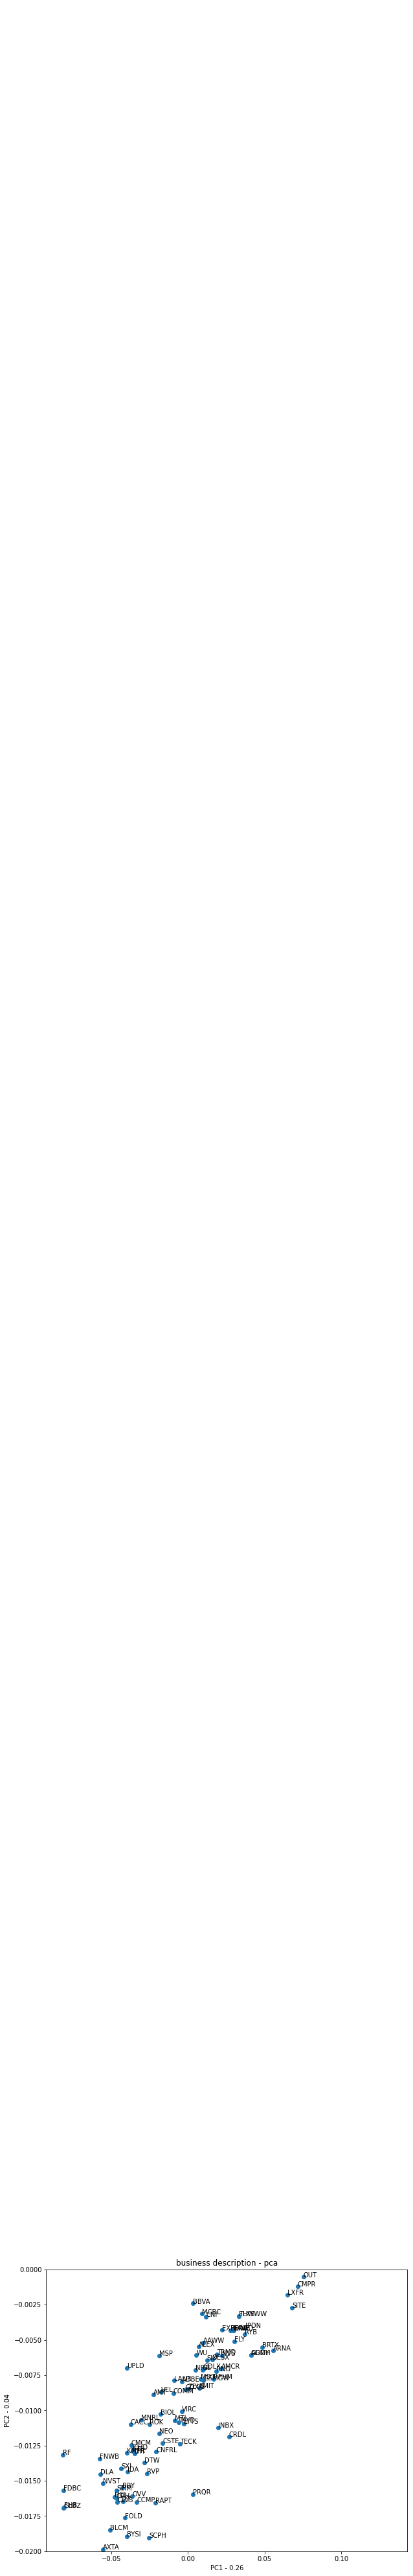

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(10,8))
data = busdesc_pca_.sample(100, random_state=2)
ax = plt.scatter(data.pc1, data.pc2)

# annotate ticker names
for ticker, row in data.iterrows():
    plt.annotate(ticker, (row.pc1, row.pc2))
plt.xlabel(f'PC1 - {pca.explained_variance_ratio_[0]:.2f}')
plt.ylabel(f'PC2 - {pca.explained_variance_ratio_[1]:.2f}')
plt.ylim((-0.02, -0.0))
plt.title("business description - pca")
plt.show()

In [ ]:
# KMeans clustering
from sklearn.metrics import silhouette_score
X = busdesc_pca_.replace(float("inf"), 999999.).replace(float("-inf"), -999999.).values
distortions = {}
sil = {}
for i in range(2, 16):
    km = KMeans(n_clusters=i, random_state=1)
    km.fit(X)
    y_hat = km.predict(X)
    distortions[i] = km.inertia_
    sil[i] = silhouette_score(X, y_hat)

Text(0.5, 1.0, 'elbow method')

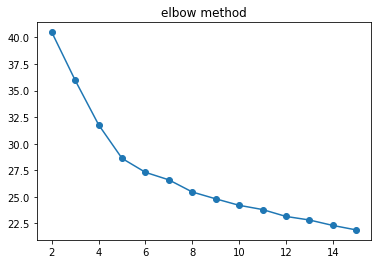

In [ ]:
plt.plot(list(distortions.keys()), list(distortions.values()), marker="o")
plt.title("elbow method")

Text(0.5, 1.0, 'silhouette method')

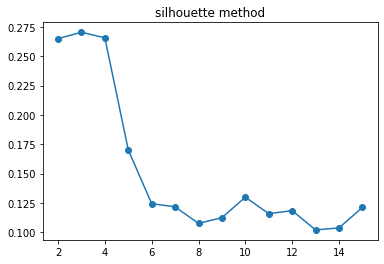

In [ ]:
plt.plot(list(sil.keys()), list(sil.values()), marker="o")
plt.title("silhouette method")

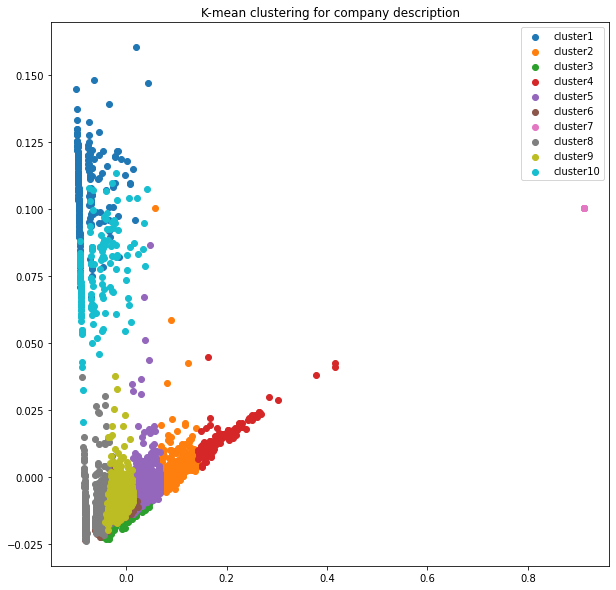

In [ ]:
# K-means clustering with k=10
km = KMeans(n_clusters=10)
km.fit(X)
y_pred = km.predict(X)
busdesc_pca_['cluster'] = y_pred

# visualization
f, ax = plt.subplots(1, figsize=(10,10))
for i in np.unique(y_pred):
    data = busdesc_pca_.query("cluster==@i")
    plt.scatter(data.pc1, data.pc2, label=f"cluster{i+1}")
# plt.ylim((-0.02, 0.01))
plt.title("K-mean clustering for company description")
plt.legend()
plt.show()

In [ ]:
busdesc_pca_.to_csv("/content/drive/MyDrive/stockClassification/kmeans_busdesc.csv")

### **1.3 Merging datasets**

In [ ]:
data1.columns.get_level_values(0).unique()

Index(['datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt', 'tic',
       'cusip', 'conm', 'curcd', 'fyr', 'acqgdwl', 'acqintan', 'act', 'am',
       'ao', 'ap', 'aqc', 'arc', 'artfs', 'at', 'bast', 'capx', 'capxv',
       'cdvc', 'dltis', 'dltr', 'dltt', 'drc', 'drlt', 'dvt', 'ebit', 'ebitda',
       'emp', 'fincf', 'fopo', 'fopt', 'ivncf', 'ni', 'oancf', 'pi', 'sale',
       'seq', 'spid', 'tie', 'tii', 'udpfa', 'unwcc', 'wcap', 'xdp', 'xrd',
       'xsga', 'xstf', 'xstfo', 'exchg', 'cik', 'costat', 'fic', 'dvpsp_c',
       'dvpsx_c', 'prcc_c', 'prch_c', 'prcl_c', 'dvpsp_f', 'dvpsx_f', 'mkvalt',
       'prcc_f', 'prch_f', 'prcl_f', 'au', 'auop', 'auopic', 'busdesc',
       'conml', 'ggroup', 'gind', 'gsector', 'gsubind', 'priusa', 'sic',
       'spcindcd', 'spcseccd', 'spcsrc', 'weburl', 'dldte', 'ipodate',
       'TICKER', 'ipoyear'],
      dtype='object')

In [ ]:
# newdata = pd.read_csv("/content/drive/MyDrive/stockClassification/data2_nasdaq.csv", header=[0,1], index_col=0, dtype=float)
# newdata1 = pd.read_csv("/content/drive/MyDrive/stockClassification/data1_nasdaq.csv", header=[0,1], index_col=0, dtype=float)
# desc = pd.read_csv("/content/drive/MyDrive/stockClassification/businessdescription_nasdaq.csv", header=0, index_col=0, dtype=float)
# busdesc_pca_ = pd.read_csv("/content/drive/MyDrive/stockClassification/kmeans_busdesc.csv", header=0, index_col=0, dtype=float)


def mergeData(p_end, data1=newdata, data2=newdata1, desc=desc, buscluster=busdesc_pca_):
    """merge datasets to create train dataset"""
    # p_end = 2010.
    tmp = slice_data(data1, 'year', p_end)
    ratios = pd.DataFrame(dtype=float, index=tmp.index)
    for fld in tmp.columns.get_level_values(0).unique():
        # print(fld)
        if fld not in ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 
                       'pe_exi', 'pe_inc', 'ps', 'pcf', 'ptb', 'PEG_trailing',
                        'divyield']: # skip valuation
            d = tmp[fld]
            ratios.loc[:, fld+"_avg"] = d.mean(axis='columns')
            ratios.loc[:, fld+"_t10y_avg"] = d.iloc[:, d.columns >= p_end - 10].mean(axis='columns')
            ratios.loc[:, fld+"_t5y_avg"] = d.iloc[:, d.columns >= p_end - 5].mean(axis='columns')
            ratios.loc[:, fld+"_t3y_avg"] = d.iloc[:, d.columns >= p_end - 3].mean(axis='columns')
            ratios.loc[:, fld+"_std"] = d.std(axis='columns')
            ratios.loc[:, fld+"_t10y_std"] = d.iloc[:, d.columns >= p_end - 10].std(axis='columns')
            ratios.loc[:, fld+"_t5y_std"] = d.iloc[:, d.columns >= p_end - 5].std(axis='columns')
            ratios.loc[:, fld+"_t3y_std"] = d.iloc[:, d.columns >= p_end - 3].std(axis='columns')
            # print("ok")
            # print("\n-------\n")
        
    # get growth rates
    tmp = slice_data(data2, 'fyear', p_end)
    growth_size = pd.DataFrame(dtype=float, index=tmp.index)
    for fld in ['ebit', 'ebitda', 'emp', 'fincf', 'fopo', 'capx', 'sale', 'ni']:
        d = tmp[fld]
        growth_size.loc[:, fld+"_5_yrgrowth"] = (d.iloc[:, d.columns == p_end-1].values / d.iloc[:, d.columns == p_end - 5 - 1])**0.2 -1
        growth_size.loc[:, fld+"_10_yrgrowth"] = (d.iloc[:, d.columns == p_end-1].values / d.iloc[:, d.columns == p_end - 10 - 1])**0.1 -1
        growth_size.loc[:, fld+"_3_yrgrowth"] = (d.iloc[:, d.columns == p_end-1].values / d.iloc[:, d.columns == p_end - 3 - 1])**(1/3) -1

    # size factors
    size_age = pd.DataFrame(dtype=float, index=tmp.index)
    for fld in ['emp', 'sale', 'mkvalt', 'ipoyear', 'dldte']:
        d = tmp[fld]
        size_age.loc[:, fld] = d.iloc[:, -1]
        size_age.loc[:, fld+"qtile"] = pd.qcut(d.iloc[:, -1], q=10, labels=list(range(10)))
        if fld not in ['ipoyear', 'dldte']:
            size_age.loc[:, fld+"_t5y_avg"] = d.iloc[:, d.columns >= p_end - 5].mean(axis='columns')
            size_age.loc[:, fld+"_t3y_avg"] = d.iloc[:, d.columns >= p_end - 3].mean(axis='columns')
    
    for fld in ['wcap', 'aqc', 'capx']:
        d = tmp[fld].values / tmp['sale']
        size_age.loc[:, fld+"%_t5y_avg"] = d.iloc[:, d.columns >= p_end - 5].mean(axis='columns')
        size_age.loc[:, fld+"%_t3y_avg"] = d.iloc[:, d.columns >= p_end - 3].mean(axis='columns')

    def mergeByTicker(left, right):
        return left.merge(right, how='outer', left_on='TICKER', right_on='TICKER')

    merged = mergeByTicker(ratios, growth_size)
    merged = mergeByTicker(merged, size_age)
    right = buscluster.cluster.to_frame()
    right.index.names = ['TICKER']
    merged = mergeByTicker(merged, right)
    right = desc.loc[:, ["TICKER", "ggroup", "gsector", "gind"]
            ].merge(right, how='outer', left_on='TICKER', right_on='TICKER')
    merged = mergeByTicker(merged, right)

    # add features relative to sector avg
    return merged


In [ ]:
merged_to2020 = mergeData(p_end=2020.)
merged_to2015 = mergeData(p_end=2015.)
merged_to2010 = mergeData(p_end=2010.)

In [ ]:
# save processed dataset 
merged_to2015.to_csv("/content/drive/MyDrive/stockClassification/nasdaq_X_upto2015.csv")
merged_to2010.to_csv("/content/drive/MyDrive/stockClassification/nasdaq_X_upto2010.csv")
merged_to2020.to_csv("/content/drive/MyDrive/stockClassification/nasdaq_X_upto2020.csv")

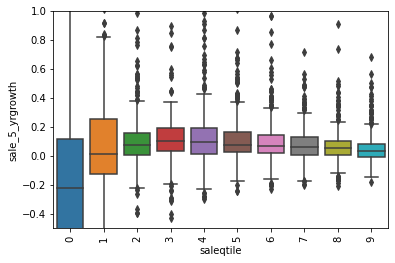

In [ ]:
import seaborn as sns
sns.boxplot(x=merged_to2020.saleqtile, y=merged_to2020.sale_5_yrgrowth)
# plt.yscale('log')plt.xscale("log")
# plt.xlim((10e0, 10e6))
plt.ylim((-0.5, 1))
plt.xticks(rotation=90)
plt.show()

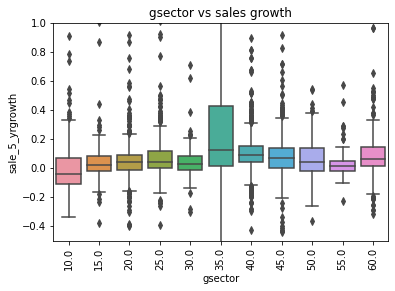

In [ ]:
import seaborn as sns
sns.boxplot(x=merged_to2020.gsector, y=merged_to2020.sale_5_yrgrowth)
plt.ylim((-0.5, 1))
plt.xticks(rotation=90)
plt.title("gsector vs sales growth")
plt.show()

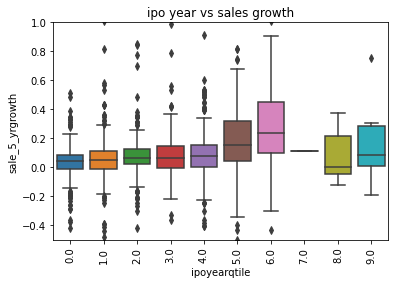

In [ ]:
import seaborn as sns
sns.boxplot(x=merged_to2020.ipoyearqtile, y=merged_to2020.sale_5_yrgrowth)
plt.ylim((-0.5, 1))
plt.xticks(rotation=90)
plt.title("ipo year vs sales growth")
plt.show()

In [ ]:
merged_to2020 = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_X_upto2020.csv", 
                            header=0, index_col=0)

grouped_mean = merged_to2020.pivot_table(index='ipoyearqtile', columns='saleqtile', aggfunc=np.mean).sale_3_yrgrowth
grouped_std = merged_to2020.pivot_table(index='ipoyearqtile', columns='saleqtile', aggfunc=np.std).sale_3_yrgrowth

In [ ]:
grouped_mean.sort_index(axis='columns')

saleqtile,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
ipoyearqtile,,,,,,,,,,
0.0,-0.314570,-0.100722,inf,0.523282,0.015378,0.053147,0.072109,0.063352,0.085957,0.062009
1.0,-0.378652,inf,0.027878,0.163837,0.153993,0.121286,0.098876,0.080286,0.088048,0.115264
2.0,-0.407488,-0.029934,inf,inf,0.095762,0.117898,0.144524,0.073273,0.070657,0.078621
3.0,-0.544981,inf,0.080853,inf,0.148568,0.101046,0.110596,0.096253,0.077821,0.131804
4.0,0.081051,inf,0.099307,0.321881,0.076110,inf,0.124185,0.174310,0.144191,0.134793
5.0,inf,inf,inf,inf,0.313427,0.188246,0.106091,0.197952,0.177843,0.190107
6.0,inf,inf,inf,inf,0.473830,inf,inf,0.237720,0.270456,0.285738
7.0,inf,inf,inf,0.658788,0.488564,0.615577,inf,0.124785,0.788906,-0.015951
8.0,NaN,0.207425,-0.057244,0.143091,NaN,NaN,0.094769,NaN,NaN,NaN


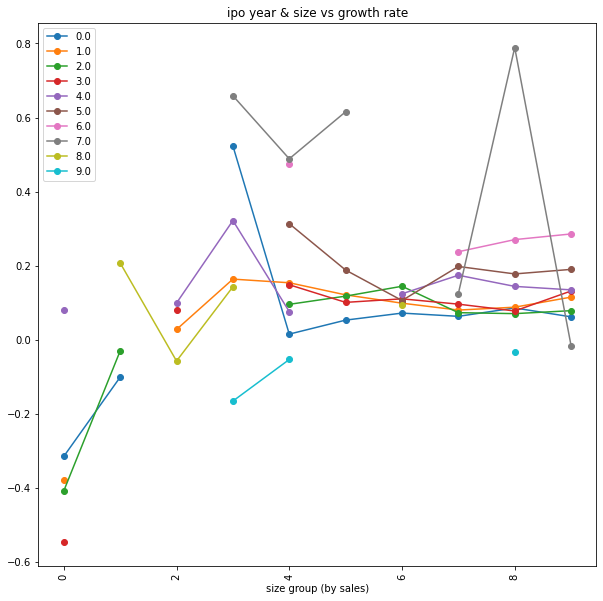

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(10,10))
ax.xticks = range(len(grouped_mean.columns))
ax.xtick_labels = sorted(grouped_mean.columns)
for i, row in grouped_mean.iterrows():
    # ax.append(plt.subplot)
    ax = plt.plot(row.index, row, label=i, marker='o')
plt.xticks(rotation=90)
plt.title("ipo year & size vs growth rate")
plt.xlabel("size group (by sales)")
plt.legend()

## **2. Make Predictions**

### 2.1 Predict F5YR EBITDA growth

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
non_numeric_cols = [col for col in dataset_10.columns 
                    if col not in dataset_10.select_dtypes(include=numerics).columns]
non_numeric_cols

['TICKER',
 'empqtile',
 'saleqtile',
 'mkvaltqtile',
 'ipoyearqtile',
 'dldteqtile']

In [ ]:
def getTarget(field, p_end, lookahead, data=newdata1):
    '''returns 1d pd.DataFrame with the target variable's cagr'''
    tmp = slice_data(data, 'fyear', p_end + lookahead)
    d = tmp[field]
    y = (d.iloc[:, d.columns == p_end + lookahead-1].values / d.iloc[:, d.columns == p_end])**(1/lookahead) -1
    return y

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


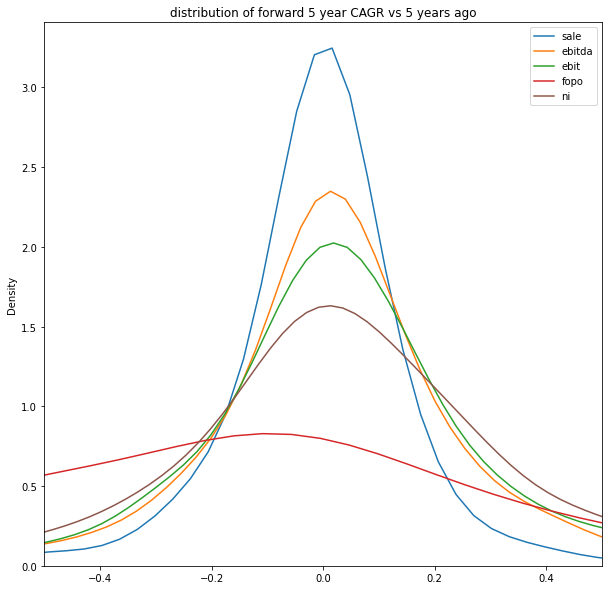

In [ ]:
# plot distribution of target variable
import seaborn as sns
f, ax = plt.subplots(1, figsize=(10, 10))
for field in ['sale', 'ebitda', 'ebit', 'fopo', 'fopt', 'ni']:
    ax = sns.kdeplot(x=(getTarget(field=field, lookahead=5, p_end=2010.).iloc[:,0] - 
                        getTarget(field=field, lookahead=5, p_end=2005.).iloc[:,0].values).values, 
                     label=field)
plt.xlim(-0.5, 0.5)
plt.legend()
plt.title("distribution of forward 5 year CAGR vs 5 years ago")
plt.show()

In [ ]:
# binning for target variable
y = pd.DataFrame(getTarget('ebitda', lookahead=5, p_end=2010.).values - getTarget('ebitda', lookahead=5, p_end=2005.).values,
             index=newdata1.index)
y.columns = ['f5yr_ebitda_cagr_chg']
bins = np.concatenate([np.arange(-0.2, -0.1, 0.1), 
                       np.arange(-0.1, 0.1, 0.05), 
                       np.arange(0.1, 0.6, 0.1)])
y['bins'] = np.digitize(y.f5yr_ebitda_cagr_chg, 
                        bins=bins, 
                        right=True)
y =y[~y.f5yr_ebitda_cagr_chg.isna()] # filter away na
bins_lookup = dict(zip(range(1, len(bins)), 
                       [f"{bins[i-1]:.2f}<x<={bins[i]:.2f}" for i in range(1, len(bins))]))
bins_lookup[0] = 'x<=-0.20'
bins_lookup[len(bins)] = 'x>0.50'

dataset_10 = merged_to2010.merge(y.bins.to_frame(), 
                       how='outer', left_on='TICKER', right_on='TICKER')
dataset_10 = dataset_10[~dataset_10.bins.isna()]

# remove entries with more than 60% of the fields empty
dataset_10 = dataset_10.loc[(dataset_10.isna().sum(axis='columns') / len(dataset_10.columns) < 0.6), :]

# reindex
dataset_10.index = range(len(dataset_10))

# label encoding
les = {}
for col in ['ggroup', 'gsector']:
    les[col] = LabelEncoder()
    dataset_10.loc[:, col] = les[col].fit_transform(dataset_10.loc[:, col]) 

In [ ]:
dataset_10.to_csv("/content/drive/MyDrive/stockClassification/nasdaq_traindata_upto2010.csv")

In [ ]:
Counter(y.bins)

Counter({0: 261,
         1: 192,
         2: 186,
         3: 249,
         4: 265,
         5: 205,
         6: 269,
         7: 144,
         8: 76,
         9: 50,
         10: 63})

In [ ]:
bins_lookup

{0: 'x<=-0.20',
 1: '-0.20<x<=-0.10',
 2: '-0.10<x<=-0.05',
 3: '-0.05<x<=0.00',
 4: '0.00<x<=0.05',
 5: '0.05<x<=0.10',
 6: '0.10<x<=0.20',
 7: '0.20<x<=0.30',
 8: '0.30<x<=0.40',
 9: '0.40<x<=0.50',
 10: 'x>0.50'}

In [ ]:
dataset_10.head()

,TICKER,dpr_avg,dpr_t10y_avg,dpr_t5y_avg,dpr_t3y_avg,dpr_std,dpr_t10y_std,dpr_t5y_std,dpr_t3y_std,npm_avg,npm_t10y_avg,npm_t5y_avg,npm_t3y_avg,npm_std,npm_t10y_std,npm_t5y_std,npm_t3y_std,opmbd_avg,opmbd_t10y_avg,opmbd_t5y_avg,opmbd_t3y_avg,opmbd_std,opmbd_t10y_std,opmbd_t5y_std,opmbd_t3y_std,opmad_avg,opmad_t10y_avg,opmad_t5y_avg,opmad_t3y_avg,opmad_std,opmad_t10y_std,opmad_t5y_std,opmad_t3y_std,gpm_avg,gpm_t10y_avg,gpm_t5y_avg,gpm_t3y_avg,gpm_std,gpm_t10y_std,gpm_t5y_std,...,PEG_trailing_t5y_std,PEG_trailing_t3y_std,divyield_avg,divyield_t10y_avg,divyield_t5y_avg,divyield_t3y_avg,divyield_std,divyield_t10y_std,divyield_t5y_std,divyield_t3y_std,ebit_5_yrgrowth,ebit_10_yrgrowth,ebit_3_yrgrowth,ebitda_5_yrgrowth,ebitda_10_yrgrowth,ebitda_3_yrgrowth,emp_5_yrgrowth,emp_10_yrgrowth,emp_3_yrgrowth,fincf_5_yrgrowth,fincf_10_yrgrowth,fincf_3_yrgrowth,fopo_5_yrgrowth,fopo_10_yrgrowth,fopo_3_yrgrowth,capx_5_yrgrowth,capx_10_yrgrowth,capx_3_yrgrowth,sale_5_yrgrowth,sale_10_yrgrowth,sale_3_yrgrowth,ni_5_yrgrowth,ni_10_yrgrowth,ni_3_yrgrowth,ggroup,gsector,sic,spcseccd,cluster,bins
0,A,0.368175,0.460219,0.0000,0.000000,1.164272,1.301695,0.000000,0.000000,0.015188,0.017750,0.114050,0.09500,0.128392,0.141779,0.080724,0.035962,0.077417,0.091050,0.134650,0.151250,0.083017,0.084760,0.025611,0.014506,0.031146,0.036200,0.099850,0.117083,0.101569,0.111527,0.026862,0.015464,0.479542,0.528000,0.561800,0.581250,0.120766,0.045284,0.031555,...,0.147801,0.167938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.117790,-0.091611,-0.162062,-0.117422,-0.096354,-0.122158,-0.097120,-0.074405,-0.035085,0.352818,NaN,NaN,0.117683,0.113915,-0.008734,0.016402,-0.114941,-0.115538,-0.090007,-0.060130,-0.034130,NaN,NaN,NaN,13,5,159,6,0.0,5.0
1,AAON,0.041658,0.079150,0.1583,0.209000,0.083417,0.103051,0.090730,0.007701,0.064066,0.083275,0.082250,0.09650,0.026185,0.016259,0.020928,0.009972,0.139039,0.163725,0.164250,0.184250,0.036233,0.023796,0.029768,0.015056,0.108855,0.129800,0.126500,0.148500,0.033459,0.026145,0.032500,0.016348,0.237908,0.255125,0.250800,0.269500,0.033868,0.024329,0.029932,...,3.311048,0.062824,0.016377,0.016377,0.016377,0.016569,0.001104,0.001104,0.001104,0.001267,0.290045,0.105993,0.192044,0.240518,0.107412,0.147250,-0.029322,0.015205,-0.064967,0.004902,0.066537,0.447137,NaN,NaN,0.049845,-0.104538,0.038655,-0.180834,0.071988,0.067170,0.019522,0.298096,0.110752,0.173974,2,2,124,4,0.0,3.0
2,AAP,0.039833,0.039833,0.0717,0.096833,0.048250,0.048250,0.042427,0.008676,0.038944,0.038944,0.050750,0.04900,0.018227,0.018227,0.002556,0.000901,0.106167,0.106167,0.116950,0.114000,0.017645,0.017645,0.005170,0.004423,0.079861,0.079861,0.088000,0.084833,0.015474,0.015474,0.004975,0.002810,0.489056,0.489056,0.504850,0.507167,0.021881,0.021881,0.004080,...,1.036830,0.535639,0.006346,0.006346,0.006346,0.006320,0.000488,0.000488,0.000488,0.000449,0.066865,0.365485,0.040513,0.068980,0.226918,0.037014,0.053301,0.074434,0.038325,0.539923,NaN,0.628105,-0.118151,0.051295,0.016657,0.014239,0.062710,-0.093013,0.074995,0.093860,0.054464,0.075392,NaN,0.053379,8,3,230,9,4.0,5.0
3,AAPL,0.090021,0.000000,0.0000,0.000000,0.136510,0.000000,0.000000,0.000000,0.054274,0.083850,0.133800,0.15925,0.070628,0.062560,0.038824,0.021982,0.091845,0.111400,0.188450,0.225917,0.086912,0.093251,0.060185,0.043529,0.073000,0.096100,0.174850,0.211333,0.085731,0.094574,0.058392,0.041536,0.334250,0.313925,0.343400,0.371500,0.108895,0.044674,0.044766,...,0.011196,0.009621,0.011796,NaN,NaN,NaN,0.002254,NaN,NaN,NaN,1.020080,0.407045,0.685221,0.902476,0.387152,0.670992,0.223433,0.142212,0.221610,0.391688,0.506649,0.269569,0.795953,inf,0.633141,0.454061,0.376046,0.203059,0.389652,0.214721,0.304781,0.972200,0.299209,0.605744,18,7,134,6,0.0,0.0
4,AAWW,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058875,0.058875,0.058875,0.06650,0.020279,0.020279,0.020279,0.016371,0.120958,0.120958,0.120958,0.121833,0.025211,0.025211,0.025211,0.030802,0.093604,0.093604,0.093604,0.094250,0.022909,0.022909,0.022909

In [ ]:
dataset_10.iloc[:, :50].info()

In [ ]:
dataset_10.iloc[:, 50:100].info()

In [ ]:
dataset_10.iloc[:, -50:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   accrual_t5y_std        1770 non-null   float64
 1   accrual_t3y_std        1732 non-null   float64
 2   ptb_avg                1865 non-null   float64
 3   ptb_t10y_avg           1863 non-null   float64
 4   ptb_t5y_avg            1802 non-null   float64
 5   ptb_t3y_avg            1764 non-null   float64
 6   ptb_std                1852 non-null   float64
 7   ptb_t10y_std           1839 non-null   float64
 8   ptb_t5y_std            1757 non-null   float64
 9   ptb_t3y_std            1709 non-null   float64
 10  PEG_trailing_avg       1734 non-null   float64
 11  PEG_trailing_t10y_avg  1711 non-null   float64
 12  PEG_trailing_t5y_avg   1631 non-null   float64
 13  PEG_trailing_t3y_avg   1532 non-null   float64
 14  PEG_trailing_std       1662 non-null   float64
 15  PEG_

### 2.2 Preprocessing

In [ ]:
# imputation
from sklearn.impute import KNNImputer
dataset_10 = dataset_10[~dataset_10.bins.isna()]
X = dataset_10.drop(["TICKER", "bins"], axis="columns").replace(float("inf"), 999999999999.).replace(float("-inf"), -999999999999.)
y = dataset_10.bins.values
imputer = KNNImputer(n_neighbors=3)
X_imp = imputer.fit_transform(X)

In [ ]:
# balancing dataset
print("original classes:", Counter(y))
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=1, k_neighbors=5, n_jobs=-1)
X_res_imp, y_res = smote.fit_resample(X_imp, y)
print("balanced classes", Counter(y_res))

original classes: Counter({6.0: 245, 4.0: 230, 3.0: 206, 5.0: 190, 0.0: 182, 2.0: 128, 7.0: 127, 1.0: 126, 8.0: 66, 10.0: 50, 9.0: 42})
balanced classes Counter({5.0: 245, 3.0: 245, 0.0: 245, 6.0: 245, 10.0: 245, 7.0: 245, 4.0: 245, 8.0: 245, 1.0: 245, 2.0: 245, 9.0: 245})


In [ ]:
## commented out - will scale in the pipeline
# # scaling

# scaler = StandardScaler()
# X_imp_sc = scaler.fit_transform(X_res_imp)

### 2.3 EDA

[0.12263705 0.08943189]


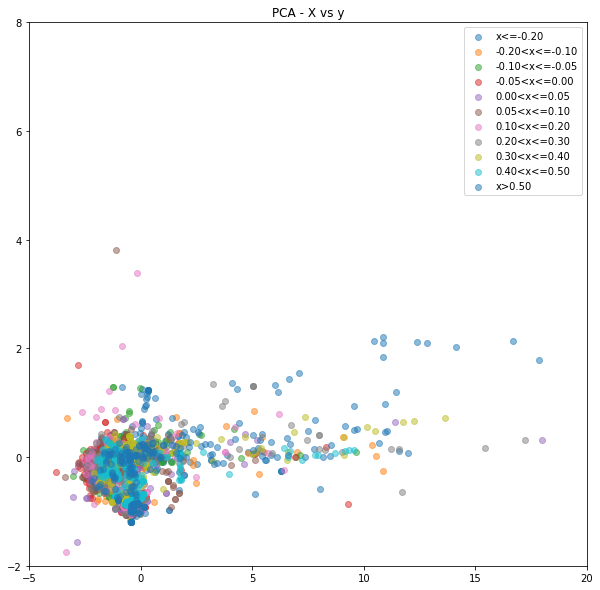

In [ ]:
# PCA
scaler = StandardScaler()
X_imp_sc = scaler.fit_transform(X_res_imp)
pca = PCA(n_components=2)
pca.fit(X_imp_sc)
print(pca.explained_variance_ratio_)

X_pca = pd.DataFrame(pca.fit_transform(X_imp_sc), columns=['pc1', 'pc2'])
X_pca['target'] = y_res

f, ax = plt.subplots(1, figsize=(10, 10))
for cat in np.unique(y_res):
    d = X_pca.query(f"target=={cat}")
    ax = plt.scatter(d.pc1, d.pc2, label=bins_lookup[cat], alpha=0.5)
plt.legend()
plt.title("PCA - X vs y")
plt.ylim((-2, 8))
plt.xlim(-5, 20)
plt.show()

### 2.4 10-fold validation with logistic regression

In [ ]:
print(len(X_res_imp))
print(len(y_res))

4686
4686


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_res_imp, y_res, 
                                                    test_size=0.20, 
                                                    stratify=y_res, 
                                                    random_state=1)

In [ ]:
# logistic regression
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=10), LogisticRegression(random_state=1, solver='lbfgs'))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f'Test Accuracy: {pipe_lr.score(X_test, y_test):.3f}')

Test Accuracy: 0.239


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


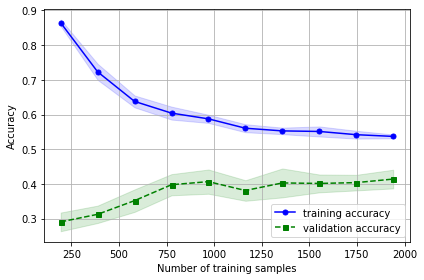

In [ ]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
pipe_lr = make_pipeline(
                        # StandardScaler(), 
                        # PCA(n_components=50), 
                        DecisionTreeClassifier(random_state=1, max_depth=6, criterion='entropy')
                        )

# learning curve for model tuninig
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                         train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# pipe_lr.fit(X_train, y_train)
# y_pred = pipe_lr.predict(X_test)
# print(f'Test Accuracy: {pipe_lr.score(X_test, y_test):.3f}')


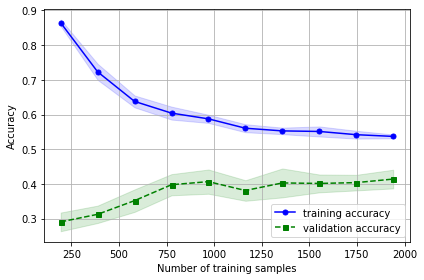

In [ ]:
# SVM
from sklearn.svm import SVC
# for C in [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]:
#     pipe_lr = make_pipeline(StandardScaler(), 
#                             PCA(n_components=20), 
#                             SVC(random_state=1, C=C, kernel='rbf'))
#     pipe_lr.fit(X_train, y_train)
#     y_pred = pipe_lr.predict(X_test)
#     print(f'C = {C}; Test Accuracy = {pipe_lr.score(X_test, y_test):.3f}')
    
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                         train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)
pipe_lr = make_pipeline(StandardScaler(), 
                            PCA(n_components=20), 
                            SVC(random_state=1, C=1000, kernel='rbf'))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [ ]:
# adaboost
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=1, max_depth=6, criterion='entropy')
svc = SVC(random_state=1, C=1000, kernel='rbf')
# pipe_lr_10_svc = make_pipeline(StandardScaler(), 
#                            PCA(n_components=30), 
#                            AdaBoostClassifier(
#                                 base_estimator=svc, 
#                                 n_estimators=300,
#                                 algorithm='SAMME')
#                         )
pipe_lr_10 = make_pipeline(
                        #    StandardScaler(), 
                        #    PCA(n_components=50), 
                           AdaBoostClassifier(
                                base_estimator=dtc, 
                                n_estimators=100,
                                algorithm='SAMME.R')
                        )
pipe_lr_10.fit(X_train, y_train)
y_pred = pipe_lr_10.predict(X_test)
print(f'Test Accuracy: {pipe_lr_10.score(X_test, y_test):.3f}')

Test Accuracy: 0.688


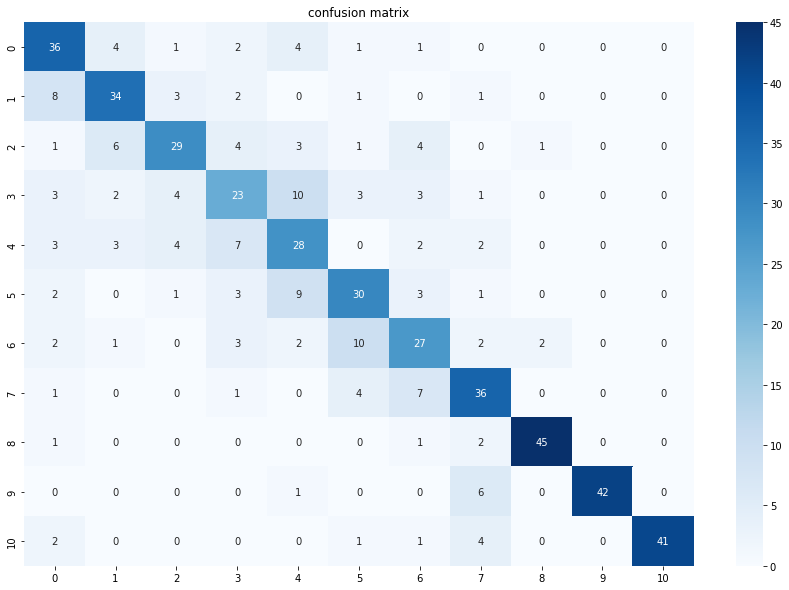

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
f, ax = plt.subplots(1, figsize=(15, 10))
ax = sns.heatmap(conf_mat, cmap='Blues', annot=True)
plt.title("confusion matrix")
plt.show()

In [ ]:
# k-fold validation with k=10
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.unique(y_train[train]), score))  
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.519
Fold:  2, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.579
Fold:  3, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.500
Fold:  4, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.602
Fold:  5, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.593
Fold:  6, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.551
Fold:  7, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.521
Fold:  8, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.530
Fold:  9, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.530
Fold: 10, Class dist.: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], Acc: 0.567

CV accuracy: 0.549 +/- 0.033


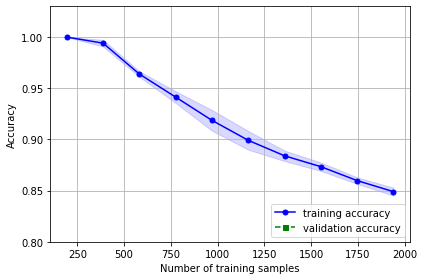

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(), 
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           solver='liblinear'))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                         train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

## **3. Save model**

In [ ]:
import pickle
filename = '/content/drive/MyDrive/stockClassification/nasdaq_adaboost_ebtida_model.sav'
pickle.dump(pipe_lr_10, open(filename, 'wb'))

## **4. Test on real data 5 years later**

In [ ]:
# binning for target variable
y_15 = pd.DataFrame(getTarget('ebitda', lookahead=5, p_end=2015.).values - getTarget('ebitda', lookahead=5, p_end=2010.).values,
             index=newdata1.index)
y_15.columns = ['f5yr_ebitda_cagr_chg']
y_15['bins'] = np.digitize(y_15.f5yr_ebitda_cagr_chg, 
                        bins=bins, 
                        right=True)
y_15 = y_15[~y_15.f5yr_ebitda_cagr_chg.isna()] # filter away na

dataset_15 = merged_to2015.merge(y_15, 
                       how='outer', left_on='TICKER', right_on='TICKER')
dataset_15 = dataset_15[~dataset_15.bins.isna()]
dataset_15.index = range(len(dataset_15))
dataset_15 = dataset_15.loc[(dataset_15.isna().sum(axis='columns') / len(dataset_15.columns) < 0.6), :]

# label encoding
# les already defined
for col in ['ggroup', 'gsector']:
    # les[col] = LabelEncoder()
    dataset_15.loc[:, col] = les[col].fit_transform(dataset_15.loc[:, col]) 

In [ ]:
dataset_15

In [ ]:
dataset_15.to_csv("/content/drive/MyDrive/stockClassification/nasdaq_traindata_upto2015.csv")

In [ ]:
# X, y seperation
dataset_15 = dataset_15[~dataset_15.bins.isna()]
X_15 = dataset_15.drop(["TICKER", "bins", 'f5yr_ebitda_cagr_chg'], axis="columns").replace(float("inf"), 999999999999.).replace(float("-inf"), -999999999999.)
y_15 = dataset_15.bins.values
print(Counter(y_15))

# imputation
from sklearn.impute import KNNImputer
X_imp_15 = imputer.transform(X_15)
# X_imp_15_sc = scaler.transform(X_imp_15)

Counter({4.0: 324, 3.0: 314, 0.0: 278, 1.0: 274, 2.0: 233, 6.0: 172, 5.0: 167, 7.0: 67, 8.0: 28, 10.0: 24, 9.0: 17})


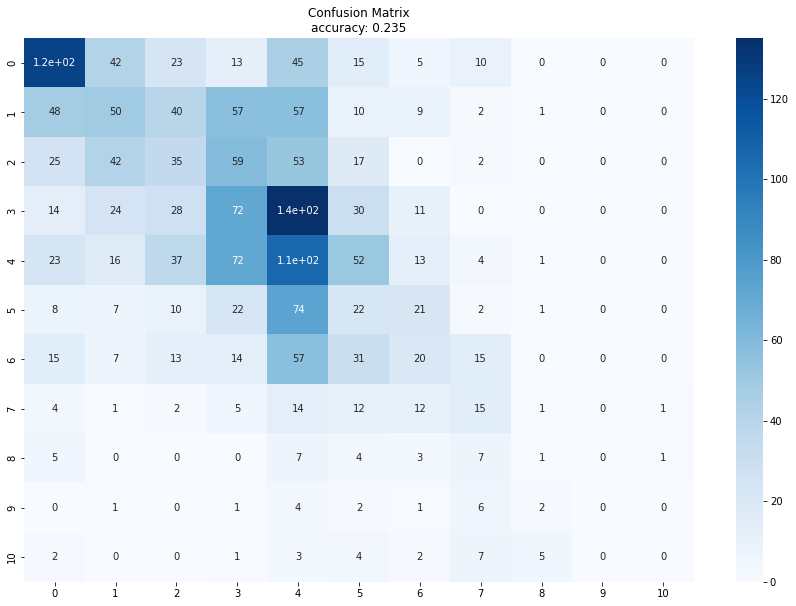

In [ ]:
y_pred_15 = pipe_lr_10.predict(X_imp_15)
conf_mt = confusion_matrix(y_true=y_15, y_pred=y_pred_15)
f, ax = plt.subplots(1, figsize=(15,10))
ax = sns.heatmap(conf_mt, cmap="Blues", annot=True)
plt.title(f"Confusion Matrix\naccuracy: {accuracy_score(y_pred_15, y_15):.3f}")
plt.show()

In [ ]:
results = pd.DataFrame([[bins_lookup[i] for i in y_pred_15],
                        y_pred_15, 
                        dataset_15.f5yr_ebitda_cagr_chg,
                        [bins_lookup[i] for i in y_15],
                        y_15], 
                       columns=dataset_15.TICKER, index=['prediction', 'predicted_class', 'actual_cagr', 'actual', 'actual_class']).T

In [ ]:
results.head(20)

,prediction,predicted_class,actual_cagr,actual,actual_class
TICKER,,,,,
A,0.00<x<=0.05,4,0.00226924,0.00<x<=0.05,4
AAL,-0.20<x<=-0.10,1,-0.457586,x<=-0.20,0
AAME,-0.05<x<=0.00,3,-0.213172,x<=-0.20,0
AAON,x<=-0.20,0,-0.127499,-0.20<x<=-0.10,1
AAP,0.00<x<=0.05,4,-0.142749,-0.20<x<=-0.10,1
AAPL,-0.10<x<=-0.05,2,-0.269488,x<=-0.20,0
AAWW,-0.05<x<=0.00,3,-0.0124674,-0.05<x<=0.00,3
ABBV,0.00<x<=0.05,4,0.0926404,0.05<x<=0.10,5
ABC,-0.05<x<=0.00,3,0.0613663,0.05<x<=0.10,5


In [ ]:
# feature importance
feature_importance = pd.DataFrame(pipe_lr_10.steps[-1][1].feature_importances_, index=X_15, columns=['feature_importance'])
feature_importance = feature_importance.sort_values('feature_importance', ascending=False)
f, ax = plt.subplots(1, figsize=(5, 50))
ax = plt.barh(feature_importance.head(100).index, feature_importance.head(100).feature_importance)
plt.title("Adaboost - feature importance")
plt.show()

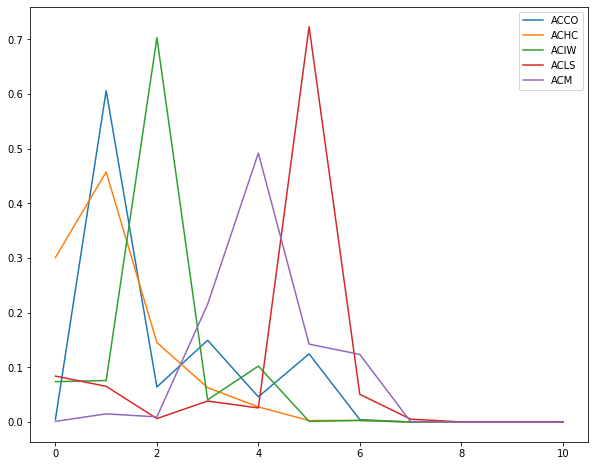

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 8))
for arr, ticker in zip(pipe_lr_10.predict_proba(X_imp_15[15:20]), dataset_15.TICKER[15:20]):
    ax = plt.plot(list(range(len(arr))), arr, label = ticker)
plt.legend()
plt.show()

## **5. Train on 2015 data for actual predictions**

In [ ]:
merged_to2015 = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_X_upto2015.csv")
merged_to2010 = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_X_upto2010.csv")
merged_to2020 = pd.read_csv("/content/drive/MyDrive/stockClassification/nasdaq_X_upto2020.csv")

In [ ]:
dataset_15.query("roe_avg>0.4")

,TICKER,dpr_avg,dpr_t10y_avg,dpr_t5y_avg,dpr_t3y_avg,dpr_std,dpr_t10y_std,dpr_t5y_std,dpr_t3y_std,npm_avg,npm_t10y_avg,npm_t5y_avg,npm_t3y_avg,npm_std,npm_t10y_std,npm_t5y_std,npm_t3y_std,opmbd_avg,opmbd_t10y_avg,opmbd_t5y_avg,opmbd_t3y_avg,opmbd_std,opmbd_t10y_std,opmbd_t5y_std,opmbd_t3y_std,opmad_avg,opmad_t10y_avg,opmad_t5y_avg,opmad_t3y_avg,opmad_std,opmad_t10y_std,opmad_t5y_std,opmad_t3y_std,gpm_avg,gpm_t10y_avg,gpm_t5y_avg,gpm_t3y_avg,gpm_std,gpm_t10y_std,gpm_t5y_std,...,fopo_10_yrgrowth,fopo_3_yrgrowth,capx_5_yrgrowth,capx_10_yrgrowth,capx_3_yrgrowth,sale_5_yrgrowth,sale_10_yrgrowth,sale_3_yrgrowth,ni_5_yrgrowth,ni_10_yrgrowth,ni_3_yrgrowth,emp,empqtile,emp_t5y_avg,emp_t3y_avg,sale,saleqtile,sale_t5y_avg,sale_t3y_avg,mkvalt,mkvaltqtile,mkvalt_t5y_avg,mkvalt_t3y_avg,ipoyear,ipoyearqtile,dldte,dldteqtile,wcap%_t5y_avg,wcap%_t3y_avg,aqc%_t5y_avg,aqc%_t3y_avg,capx%_t5y_avg,capx%_t3y_avg,cluster_x,ggroup,gsector,gind,cluster_y,f5yr_ebitda_cagr_chg,bins
8,ABBV,0.620125,0.620125,0.620125,0.620125,0.377772,0.377772,0.377772,0.377772,0.217125,0.217125,0.217125,0.217125,0.054978,0.054978,0.054978,0.054978,0.381375,0.381375,0.381375,0.381375,0.024218,0.024218,0.024218,0.024218,0.334750,0.334750,0.334750,0.334750,0.017678,0.017678,0.017678,0.017678,0.811750,0.811750,0.811750,0.811750,0.001061,0.001061,0.001061,...,NaN,0.286030,NaN,NaN,0.198481,NaN,NaN,0.045936,NaN,NaN,-0.197544,26.000,8,24.166667,24.166667,19960.000,9,18042.3364,19043.333333,104140.4962,9,93984.51530,93984.515300,NaN,NaN,NaN,NaN,0.330785,0.428447,0.091624,NaN,0.024790,0.024970,8.0,13,5,352010.0,8.0,0.092640,5.0
35,ADS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.079756,0.098300,0.100500,0.110583,0.037951,0.011914,0.014606,0.003301,0.249589,0.276475,0.296000,0.302333,0.053560,0.033366,0.013946,0.011980,0.184071,0.217500,0.244800,0.252000,0.065994,0.038962,0.017944,0.016750,0.320726,0.353400,0.414050,0.410167,0.077534,0.066030,0.015155,...,0.184115,0.162575,0.245392,0.126251,0.292470,0.219719,0.154790,0.186686,0.278780,0.169866,0.159520,15.000,8,10.780000,12.566667,5302.940,8,3845.6202,4421.131000,18253.4226,9,9562.24474,12995.998133,NaN,NaN,NaN,NaN,1.116920,1.301723,0.101597,0.117638,0.028209,0.031083,5.0,17,7,451020.0,5.0,-0.161248,1.0
38,ADXS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.905667,-17.905667,-17.905667,-17.905667,NaN,NaN,NaN,NaN,-17.424667,-17.424667,-17.424667,-17.424667,NaN,NaN,NaN,NaN,-17.621333,-17.621333,-17.621333,-17.621333,NaN,NaN,NaN,NaN,-19.049000,-19.049000,-19.049000,-19.049000,NaN,NaN,NaN,...,NaN,NaN,inf,NaN,inf,1.016396,NaN,inf,NaN,NaN,0.267457,0.020,0,0.015250,0.016333,1.000,0,0.3016,0.333333,62.4234,1,39.29842,43.834133,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,inf,inf,2.0,13,5,352010.0,2.0,-0.399122,0.0
89,AMCX,0.047000,0.047000,0.047000,0.035167,0.055077,0.055077,0.055077,0.060910,0.128125,0.128125,0.128125,0.134667,0.023838,0.023838,0.023838,0.024405,0.333750,0.333750,0.333750,0.324500,0.030057,0.030057,0.030057,0.029013,0.275187,0.275187,0.275187,0.275250,0.008189,0.008189,0.008189,0.010028,0.610687,0.610687,0.610687,0.598083,0.042728,0.042728,0.042728,...,NaN,0.233253,NaN,NaN,0.372477,NaN,NaN,0.223550,NaN,NaN,0.272887,1.933,5,1.524000,1.713333,2175.641,7,1477.2234,1706.692000,4593.7995,7,3950.95290,4366.405533,2011.0,6,NaN,NaN,0.375399,0.407018,0.109036,0.181538,0.015237,0.015751,8.0,21,8,502010.0,8.0,-0.093283,2.0
192,AZO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083299,0.102150,0.106800,0.110083,0.019781,0.006065,0.005176,0.002504,0.170663,0.204375,0.212450,0.216667,0.034274,0.009681,0.006477,0.003215,0.146604,0.179325,0.187150,0.191417,0.033287,0.009352,0.006528,0.002529,0.481125,0.529750,0.538450,0.542750,0.046564,0.011009,0.006549,...,NaN,NaN,0.099829,0.090115,0.108552,0.068076,0.053306,0.054840,0.102393,0.065690,0.080095,76.000,9,69.000000,72.333333,9475.313,8,8532.4594,9075.568667,17406.6874,9,13394.90104,15066.165233,1991.0,0,NaN,NaN,-0.083585,-0.092477,0.002538,0.004230,

In [ ]:
# imputation
from sklearn.impute import KNNImputer
dataset_15 = dataset_15[~dataset_15.bins.isna()]
X = dataset_15.drop(["TICKER", "bins"], axis="columns").replace(float("inf"), 999999999999.).replace(float("-inf"), -999999999999.)
y = dataset_15.bins.values
imputer = KNNImputer(n_neighbors=3)
X_imp = imputer.fit_transform(X)

In [ ]:
# balancing dataset
print("original classes:", Counter(y))
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=1, k_neighbors=5, n_jobs=-1)
X_res_imp, y_res = smote.fit_resample(X_imp, y)
print("balanced classes", Counter(y_res))

original classes: Counter({4.0: 324, 3.0: 314, 0.0: 278, 1.0: 274, 2.0: 233, 6.0: 172, 5.0: 167, 7.0: 67, 8.0: 28, 10.0: 24, 9.0: 17})
balanced classes Counter({4.0: 324, 0.0: 324, 1.0: 324, 3.0: 324, 5.0: 324, 6.0: 324, 7.0: 324, 8.0: 324, 2.0: 324, 9.0: 324, 10.0: 324})


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_res_imp, y_res, 
                                                    test_size=0.20, 
                                                    stratify=y_res, 
                                                    random_state=1)

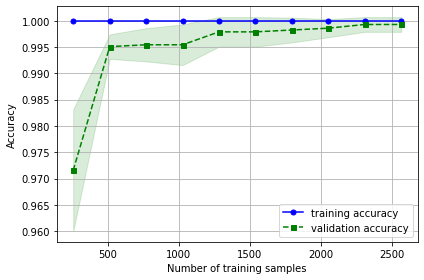

In [ ]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
pipe_lr = make_pipeline(
                        # StandardScaler(), 
                        # PCA(n_components=50), 
                        DecisionTreeClassifier(random_state=1, max_depth=6, criterion='entropy')
                        )

# learning curve for model tuninig
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                         train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# pipe_lr.fit(X_train, y_train)
# y_pred = pipe_lr.predict(X_test)
# print(f'Test Accuracy: {pipe_lr.score(X_test, y_test):.3f}')

In [ ]:
# adaboost
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=1, max_depth=6, criterion='entropy')
svc = SVC(random_state=1, C=1000, kernel='rbf')
# pipe_lr_10_svc = make_pipeline(StandardScaler(), 
#                            PCA(n_components=30), 
#                            AdaBoostClassifier(
#                                 base_estimator=svc, 
#                                 n_estimators=300,
#                                 algorithm='SAMME')
#                         )
pipe_lr_15 = make_pipeline(
                        #    StandardScaler(), 
                        #    PCA(n_components=50), 
                           AdaBoostClassifier(
                                base_estimator=dtc, 
                                n_estimators=50,
                                algorithm='SAMME.R')
                        )
pipe_lr_15.fit(X_train, y_train)
y_pred = pipe_lr_15.predict(X_test)
print(f'Test Accuracy: {pipe_lr_15.score(X_test, y_test):.3f}')

Test Accuracy: 0.999


In [ ]:
# save the new 2015 model
filename = '/content/drive/MyDrive/stockClassification/nasdaq_adaboost_ebtida_model_2015data.sav'
pickle.dump(pipe_lr_15, open(filename, 'wb'))

In [ ]:
dataset_20 = merged_to2020
dataset_15.index = range(len(dataset_20))
dataset_20 = dataset_20.loc[(dataset_20.isna().sum(axis='columns') / len(dataset_20.columns) < 0.6), :]

# label encoding
# les already defined
for col in ['ggroup', 'gsector', 'sic', 'spcseccd']:
    # les[col] = LabelEncoder()
    dataset_15.loc[:, col] = les[col].fit_transform(dataset_15.loc[:, col]) 